In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

# 1. Hyper-parameters and Dataset

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/PyTorch/Github_Series/03-advanced/'
# sample_dir = data_dir+'samples'
# # Create a directory if not exists
# if not os.path.exists(sample_dir):
#   os.makedirs(sample_dir)

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]) # Normalization reduces the skewness, helping learn faster and better.
])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=data_dir,
                                           train=True,
                                           transform=transform,
                                           download=True)

# data loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# 2. Modeling and Training

## 2.1 Generator and Discriminator

**Generator**
1. The generator model in the GAN architecture takes a point from the latent space as input and generates a new image.
2. The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training. 
3. [Activation method Tanh](https://math.paperswithcode.com/method/tanh-activation#:~:text=Tanh%20Activation%20is%20an%20activation%20function%20used%20for,it%20gave%20better%20performance%20for%20multi-layer%20neural%20networks.)

**Discriminator**
1. The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator. It could use any network architecture appropriate to the type of data it's classifying.
2. The discriminator's training data comes from two sources:
<ul>
  <li> Real data instances. The discriminator uses these instances as positive examples during training.
  <li> Fake data instances created by the generator. The discriminator uses these instances as negative examples during training.
</ul>

In [ ]:
# Generator
class Generator(nn.Module):

  def __init__(self, latent_dim, hidden_size, image_size):
    super().__init__()
    self.latent_dim = latent_dim
    self.linear1 = nn.Linear(latent_dim, hidden_size)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, image_size)
    self.tanh = nn.Tanh()

  def forward(self, x):
    out = self.linear1(x)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    out = self.tanh(out)
    return out

In [ ]:
# Discriminator
class Discriminator(nn.Module):

  def __init__(self, hidden_size, image_size):
    super().__init__()
    self.linear1 = nn.Linear(image_size, hidden_size)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.linear1(x)
    out = self.leaky_relu(out)
    out = self.linear2(out)
    out = self.leaky_relu(out)
    out = self.linear3(out)
    out = self.sigmoid(out)
    return out

## 2.2 GAN

![GAN architecture diagram](https://miro.medium.com/max/8000/1*et3fMPDclTv6ZQSf1xbkag.jpeg "GAN architecture diagram")

**Discriminator Loss**
<ul>
  <li> the loss that comes from falsely identifying real images as fake.
  <li> the loss that comes from confusing fake, generated images as real ones.
</ul>

**Generator Loss**
<ul>
  <li> the loss is actually dependent upon the classifier: the loss comes from the classifier correctly identifying generated images as fake. This has the effect of encouraging the generator to generate samples that have a low probability of being fake.
</ul>

Paper: [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf)

In [ ]:
# GAN
class GAN(nn.Module):

  def __init__(self, generator, discriminator, batch_size):
    super().__init__()

    self.latent_dim = generator.latent_dim
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
    self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
    self.criterion = nn.BCELoss()
    self.batch_size = batch_size
    self.real_labels = torch.ones(batch_size, 1).to(device)
    self.fake_labels = torch.zeros(batch_size, 1).to(device)

  def train_step_generator(self):
    # Generate fake images
    latent_vec = torch.randn(self.batch_size, self.latent_dim).to(device)
    generated_samples = self.generator(latent_vec)
    output = self.discriminator(generated_samples)
    
    # Compute generator loss
    loss = self.criterion(output, self.real_labels)

    # Backward
    self.g_optimizer.zero_grad()
    loss.backward()
    self.g_optimizer.step()
    return loss.item()

  def train_step_discriminator(self, x):
    # Compute BCE_Loss using real images
    output = self.discriminator(x)
    loss_real = self.criterion(output, self.real_labels)

    # Compute BCELoss using fake images
    latent_vec = torch.randn(self.batch_size, self.latent_dim).to(device)
    fake_images = self.generator(latent_vec)
    output = self.discriminator(fake_images)
    loss_fake = self.criterion(output, self.fake_labels)

    # Discriminator loss
    loss = loss_real + loss_fake

    # Backward
    self.d_optimizer.zero_grad()
    loss.backward()
    self.d_optimizer.step()
    return loss.item()

  def train_step(self, x):
    # Train Generator and Discriminator, and Return losses
    loss_d = self.train_step_discriminator(x)
    loss_g = self.train_step_generator()
    return loss_g, loss_d

## 2.3 Train the model

In [ ]:
# Initialize the model
generator = Generator(latent_size, hidden_size, image_size)
discriminator = Discriminator(hidden_size, image_size)
model = GAN(generator, discriminator, batch_size)

# Train the model
total_step = len(train_loader)
loss_g_arr, loss_d_arr, loss_arr = [], [], []

for epoch in range(num_epochs):
  for batch_id, (images, _) in enumerate(train_loader):

    input = images.reshape(batch_size, -1).to(device)
    loss_g, loss_d = model.train_step(input)
    loss = loss_g + loss_d

    loss_g_arr.append(loss_g)
    loss_d_arr.append(loss_d)
    loss_arr.append(loss)

    if (batch_id+1) % 100 == 0:
      print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}, Generator Loss: {:.4f}, Discriminator Loss: {:.4f}'
            .format(epoch+1, num_epochs, batch_id+1, total_step, loss, loss_g, loss_d))

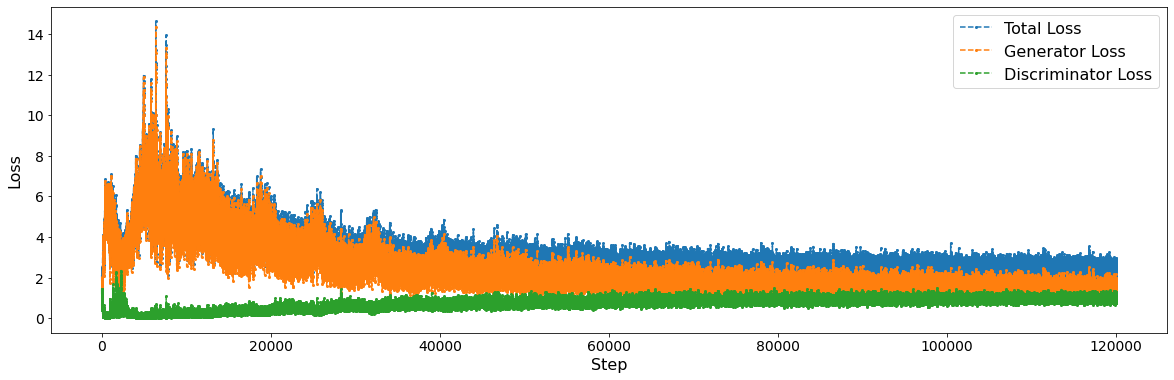

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(loss_arr, '--', marker='o', markersize=2, label='Total Loss')
plt.plot(loss_g_arr, '--', marker='o', markersize=2, label='Generator Loss')
plt.plot(loss_d_arr, '--', marker='o', markersize=2, label='Discriminator Loss')
plt.xlabel('Step', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=16)
plt.show()